# MCMC Polynomial 2nd order
- Phase Variation = 1st order sinusoid
- Polynomial = 2nd order polynomial
- version 2 of each functions are the latest version (good ones)

In [1]:
'''Import Package'''
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as sp
import scipy.optimize as spopt
from matplotlib.ticker import MaxNLocator
import emcee
import batman 
import time as t
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner
from matplotlib import gridspec
import os
from astropy.table import Table, Column
import math
#import triangle
%matplotlib inline

In [2]:
'''YO THINK ABOUT THIS NORMLIZATION THING'''

def get_data(folderdata):
    path = folderdata + '/ch2_datacube_binned_AORs579.dat'
    #Loading Data
    flux = np.loadtxt(path, usecols=[0], skiprows=1)         # photon count
    flux_err = np.loadtxt(path, usecols=[1], skiprows=1)     # photon count
    time = np.loadtxt(path, usecols=[2], skiprows=1)         # hours
    xdata = np.loadtxt(path, usecols=[4], skiprows=1)        # pixel
    ydata = np.loadtxt(path, usecols=[6], skiprows=1)        # pixel
    psfxwdat = np.loadtxt(path, usecols=[8], skiprows=1)     # pixel
    psfywdat = np.loadtxt(path, usecols=[10], skiprows=1)    # pixel
    # convert time into days
    #hrstodays=1.0/24.0
    #time = hrstodays*time
    # normalized flux (will not agree with model, so allow an offset)
    factor = 1/(np.median(flux))
    flux = factor*flux
    flux_err = factor*flux
    return flux, flux_err, time, xdata, ydata, psfxwdat, psfywdat

def get_data_psf(folderdata):
    # loading data
    photpath1 = folderdata + '/ch2_datacube_binned_AORs579.dat'
    #PSF_popt = folderdata +  '/ch2_datacube_popt_AORs579.dat'
    #PSF_pcov = folderdata + '/ch2_datacube_pcov_AORs579.dat'


    flux = np.loadtxt(photpath1, usecols=[0], skiprows=1)
    flux_err = np.loadtxt(photpath1, usecols=[1], skiprows=1)
    time = np.loadtxt(photpath1, usecols=[2], skiprows=1)
    time_err = np.loadtxt(photpath1, usecols=[3], skiprows=1)
    xdata = np.loadtxt(photpath1, usecols=[4], skiprows=1)
    ydata = np.loadtxt(photpath1, usecols=[6], skiprows=1)
    psfxw = np.loadtxt(photpath1, usecols=[8], skiprows=1)
    psfyw = np.loadtxt(photpath1, usecols=[10], skiprows=1)
    #xo2 = np.loadtxt(photpath1, usecols=[12], skiprows=1)
    #yo2 = np.loadtxt(photpath1, usecols=[14], skiprows=1)
    #psfxw2 = np.loadtxt(photpath1, usecols=[16], skiprows=1)
    #psfyw2 = np.loadtxt(photpath1, usecols=[18], skiprows=1)
    
    # conversion
    # convert time into days
    #hrstodays=1.0/24.0
    #time = hrstodays*time
    # normalized flux (will not agree with model, so allow an offset)
    factor = 1/(np.median(flux))
    flux = factor*flux
    flux_err = factor*flux
    
    return flux, flux_err, time, xdata, ydata, psfxw, psfyw

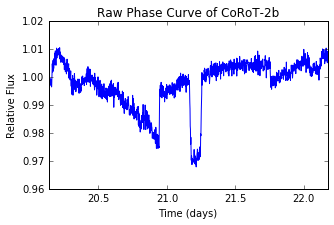

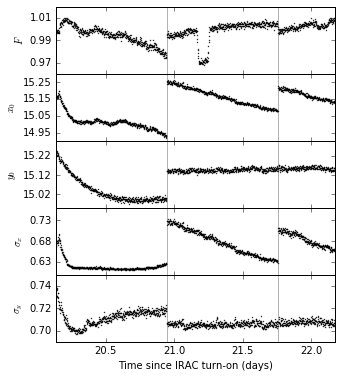

In [3]:
'''Get Data'''
foldername = 'Run4'
#flux0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = get_data_psf(foldername)
flux, flux_err, time, xdata, ydata, psfxw, psfyw = get_data_psf(foldername)


'''Sort array chronologically'''
index    = np.argsort(time)
time     = time[index]
flux     = flux[index]
xdata    = xdata[index]
ydata    = ydata[index]
psfxw    = psfxw[index]
psfyw    = psfyw[index]

'''Chop Data
flux = np.ma.masked_where(ydata0>15.18, flux0, copy = True)
flux_err = np.ma.masked_where(ydata0>15.18, flux_err0, copy = True)
xdata = np.ma.masked_where(ydata0>15.18, xdata0, copy = True)
ydata = np.ma.masked_where(ydata0>15.18, ydata0, copy = True)
psfxw = np.ma.masked_where(ydata0>15.18, psfxw0, copy = True)
psfyw = np.ma.masked_where(ydata0>15.18, psfyw0, copy = True)
time = np.ma.masked_where(ydata0>15.18, time0, copy = True)

Discarded Data
flux_out = np.ma.masked_where(ydata0<15.18, flux0)
flux_err_out = np.ma.masked_where(ydata0<15.18, flux_err0)
xdata_out = np.ma.masked_where(ydata0<15.18, xdata0)
ydata_out = np.ma.masked_where(ydata0<15.18, ydata0)
psfxw_out = np.ma.masked_where(ydata0<15.18, psfxw0)
psfyw_out = np.ma.masked_where(ydata0<15.18, psfyw0)'''

#discard = np.where(ydata > 15.18)
#print(discard)

'''Sort array chronologically'''

'''TO DO'''

plt.figure(figsize=(5,3))
plt.plot(time, flux, markersize=2)
plt.xlim(np.min(time), np.max(time))
plt.title('Raw Phase Curve of CoRoT-2b')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(5, 6))
#fig.suptitle("CoRoT-2b Observation")

axes[0].plot(time, flux,  'k.', markersize=2, alpha = 0.7)
axes[0].set_ylabel("$F$")
axes[0].set_xlim((np.min(time), np.max(time)))
axes[0].set_yticks(np.arange(0.97, 1.01, 0.02))
axes[0].axvline(x=21.75729537037037, color='k', alpha=0.3)
axes[0].axvline(x=20.94602719907407, color ='k', alpha=0.3)

axes[1].plot(time, xdata,  'k.', markersize=2, alpha = 0.7)
axes[1].set_ylabel("$x_0$")
axes[1].set_yticks(np.arange(14.95, 15.25, 0.1))
axes[1].axvline(x=21.75729537037037, color='k', alpha=0.3)
axes[1].axvline(x=20.94602719907407, color ='k', alpha=0.3)

axes[2].plot(time, ydata, 'k.', markersize=2, alpha = 0.7)
axes[2].set_ylabel("$y_0$")
axes[2].set_yticks(np.arange(15.02, 15.30, 0.1))
axes[2].set_ylim((14.95, 15.3))
axes[2].axvline(x=21.75729537037037, color='k', alpha=0.3)
axes[2].axvline(x=20.94602719907407, color ='k', alpha=0.3)

axes[3].plot(time, psfxw, 'k.', markersize=2, alpha = 0.7)
axes[3].set_ylabel("$\sigma _x$")
axes[3].set_yticks(np.arange(0.63, 0.77, 0.05))
axes[3].set_ylim((0.6, 0.76))
axes[3].axvline(x=21.75729537037037, color='k', alpha=0.3)
axes[3].axvline(x=20.94602719907407, color ='k', alpha=0.3)

axes[4].plot(time, psfyw,  'k.', markersize=2, alpha = 0.7)
axes[4].set_ylabel("$\sigma _y$")
axes[4].set_ylim((0.69, 0.75))
axes[4].set_yticks(np.arange(0.70, 0.74, 0.02))
axes[4].set_xlabel('Time since IRAC turn-on (days)')
axes[4].axvline(x=21.75729537037037, color ='k', alpha=0.3)
axes[4].axvline(x=20.94602719907407, color ='k', alpha=0.3)

fig.subplots_adjust(hspace=0)

#fig.tight_layout()
pathplot1 = foldername + '/MCMC_Poly3_1.pdf'
#fig.savefig(pathplot1)

# Astrophysical Model

- Transit = stellar flux
- $F_p$ = $\Phi (t)$ x $(E(t)-1)$

In [9]:
'''David Kipping (2015) Parametrization'''
def forward_LD(alpha_h, alpha_r, alpha_t):

    # DESCRIPTION: forward takes a set of LDCs in the alpha-parameterization and
    #              converts them to the c-parameterization. A likely common use
    #              of this subroutine would be when fitting LDCs. One would treat
    #              the alpha-parameters as the free parameters, but then convert 
    #              them to the more standard c-parameters before calling whatever 
    #              astronomical model describes one's observations.
    #
    # INPUTS: alphas=[alpha_h, alpha_r, alpha_t], all of which are bound between 0 
    #         and 1 and the latter is a wrap-around parameter.
    #
    # OUTPUTS: c = [c_2, c_3, c_4]

    # Forward modeling constants
    third = 0.333333333333333
    twopi = 6.283185307179586
    P1 = 4.500841772313891
    P2 = 17.14213562373095
    Q1 = 7.996825477806030
    Q2 = 8.566161603278331

    # Define alphas
    #alpha_h = alphas[0]
    #alpha_r = alphas[1]
    #alpha_t = alphas[2]

    # Compute LDCs
    c_2 = (alpha_h**third)*( P1 + 0.25*math.sqrt(alpha_r)*( \
        -6.0*math.cos(twopi*alpha_t) + P2*math.sin(twopi*alpha_t) ) )
    c_3 = (alpha_h**third)*( -Q1 - Q2*math.sqrt(alpha_r)*math.sin(twopi*alpha_t) )
    c_4 = (alpha_h**third)*( P1 + 0.25*math.sqrt(alpha_r)*( \
        6.0*math.cos(twopi*alpha_t) + P2*math.sin(twopi*alpha_t) ) )

    # Define c results
    #c=[0 for i in range(3)]
    #c[0] = c_2
    #c[1] = c_3
    #c[2] = c_4
    return c_2, c_3, c_4

In [10]:
def inverse_LD(c_2, c_3, c_4):

    # DESCRIPTION: inverse performs the reverse transformation of subroutine 
    #              forward. It therefore converts c-parameters into 
    #              alpha-parameters.
    #
    # INPUTS: c = [c_2, c_3, c_4] (= LDCs)
    #
    # OUTPUTS: alphas = [alpha_h, alpha_r, alpha_t]

    # Inverse modeling constants
    third = 0.3333333333333333
    twopi = 6.2831853071795865
    F1 = 0.9997221357486548
    F2 = 1.0002947195445628
    G1 = 51.396969619669996
    G2 = 51.426406871192850
    G3 = 0.5098605589396862
    G4 = 67.195959492893320
    G5 = 75.639610306789280
    H1 = 0.4666386075895370
    H2 = 0.5252750715749255

    # Define c
    #c_2 = c[0]
    #c_3 = c[1]
    #c_4 = c[2]

    # Compute inverse LDCs
    alpha_h = ( F1*c_2 + F2*c_3 + F1*c_4 )**3
    alpha_r = G3/( G1*c_2 + G2*c_3 + G1*c_4 )**2
    alpha_r = alpha_r*( 576.0*(c_2 - c_4)**2 + ( G4*c_2 + G5*c_3 + G4*c_4 )**2 )
    alpha_t = math.atan2( -H1*c_2 - H2*c_3 - H1*c_4 , third*0.5*(c_4-c_2) )
    alpha_t = ( alpha_t - twopi*math.floor( alpha_t/twopi ) )/twopi

    # Define alphas_inv results
    #alphas_inv=[0 for i in range(3)]
    #alphas_inv[0] = alpha_h
    #alphas_inv[1] = alpha_r
    #alphas_inv[2] = alpha_t
    return alpha_h, alpha_r, alpha_t

In [11]:
def phase_variation2(time, t0, per, A, B):
    # in this model, we want A+B < 1/sqrt(2) = 0.707
    #t = time - t0 + per/2
    t = time - t0
    w = 2*np.pi/per
    phase = 1 + A*(-np.cos(w*t)-1) + (B*np.sin(w*t))
    return phase

def transit_model(time, t0, per, rp, a, inc, ecc, w, c_2, c_3, c_4):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"                      #limb darkening model
    params.u = [0, c_2, c_3, c_4]                        #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_secondary = m.get_t_secondary(params)
    return flux, t_secondary

def eclipse(time, t0, per, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, t_sec):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "nonlinear"                          #limb darkening model
    params.u = [0, c_2, c_3, c_4]                                  #limb darkening coefficients
    params.fp = fp                                       #planet/star brightnes
    params.t_secondary = t_sec
    #params.t_secondary = params.t0+(params.per/2.0)
    
    m = batman.TransitModel(params, time, transittype="secondary")  #initializes model
    flux = m.light_curve(params)
    return flux

def fplanet_model2(time, A, B, t0, per, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, t_sec):
    phase = phase_variation2(time, t0, per, A, B)
    eclip = eclipse(time, t0, per, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, t_sec)
    flux = phase*(eclip - 1)
    return flux

def ideal_lightcurve2(time, t0, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, A, B):
    # create transit first and use orbital paramater to get time of superior conjunction
    transit, t_sec = transit_model(time, t0, 1.7429964, rp, a, inc, ecc, w, c_2, c_3, c_4)
    # create light curve of the planet
    fplanet = fplanet_model2(time, A, B, t0, 1.7429964, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, t_sec)
    # add both light curves
    f_total = transit + fplanet
    return f_total

In [12]:
'''Detector Model'''
def detec_model(xdata, ydata, c1, c2, c3, c4, c5, c6, mid_x, mid_y):
    x = xdata - mid_x
    y = ydata - mid_y
    # modeled as 3rd order polynomial
    det_sens = np.array(c1 + c2*x + c3*y + c4*x**2 + c5*x*y  + c6*y**2)    
    return np.array(det_sens)

'''Signal_Model'''
def signal(time, t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, fp, A, B,
          xdata, ydata, c1, c2, c3, c4, c5, c6, mid_x, mid_y):
    # re-parametrizing
    c_2, c_3, c_4 = forward_LD(alpha_h, alpha_r, alpha_t)
    lcurve = ideal_lightcurve2(time, t0, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, A, B)
    det = detec_model(xdata, ydata, c1, c2, c3, c4, c5, c6, mid_x, mid_y)
    return lcurve*det

In [13]:
'''Initialize parameters'''

# Some variable def
r_star            = 0.902              # solar radius
r_sol2jup         = 0.10045            # jupiter radius in solar radius
r_sol2AU          = 214.93946938       # AU radius in solar radius
hrs2days          = 1/24.0             # hour in days

# Transit Parameters from Gillon 2010 (10 params)
t0   = 21.20995                        # initially in hrs
per  = 1.7429964                       # initially in days
rp   = 0.168584                        # initially in jupiter radius
a    = 6.70                            # initially in AU
inc  = 88.10360                          
ecc  = 0.0143                          # dimensionless [0,1]                   
w    = 96.147
alpha_h = 0.5
alpha_r = 0.5
alpha_t = 0.5
fp   = 0.0042                          # eclipse depth in units of stellar flux
c_2, c_3, c_4 = forward_LD(alpha_h, alpha_r, alpha_t)

# Phase Variation Parameters (2 params)
A    = 0.491219
B    = -0.33684

# Detector initial parameters (10 params)
c1   = 0.999                           # 1
c2   = 0.027                           # x
c3   = 0.043                           # y
c4   = 0.061                           # x^2
c5   = -0.703                          # xy
c6   = -0.780                          # y^2

# pre-calculation
mid_x = np.mean(xdata)
mid_y = np.mean(ydata)

# Regroup into arrays
p0_astro = np.array([t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, fp])
p0_phase = np.array([A, B])
p0_detec = np.array([c1, c2, c3, c4, c5, c6])
#p0_phase = np.array([a1, a2, t1, t2])

# params only 
#p0 = np.array([t0, per, rp, a, inc, ecc, w, u1, u2, fp,a1, a2, t1, t2, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
p0 = np.array([t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, fp, A, B, c1, c2, c3, c4, c5, c6])

In [14]:
'''Detector model definition curve_fit friendly'''
def det4fit(coord, c1, c2, c3, c4, c5, c6):
    xdata, ydata = coord
    mid_x = np.mean(xdata)
    mid_y = np.mean(ydata)    
    x = xdata - mid_x
    y = ydata - mid_y
    # modeled as 3rd order polynomial
    det_sens = np.array(c1 + c2*x + c3*y + c4*x**2 + c5*x*y  + c6*y**2)    
    return np.array(det_sens)

'''Optimization to guess polynomial parameters'''

def fit_residual(flux, time, xdata, ydata, p0_astro, p0_phase, p0_detec, u_detec, l_detec):
    # Using Gillon 2010 light curve parameters
    t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, fp = p0_astro
    A, B = p0_phase
    c_2, c_3, c_4 = forward_LD(alpha_h, alpha_r, alpha_t)
    lcurve = ideal_lightcurve2(time, t0, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, A, B)
    # Get residuals
    residuals = flux/lcurve
    # Fit residual
    coord = (xdata, ydata)
    popt, pcov = spopt.curve_fit(det4fit, coord, residuals, p0=p0_detec, bounds = (l_detec, u_detec))
    return popt

[ 1.00478319  0.00969492  0.00780138 -0.5886932  -0.26604854 -0.43274052]


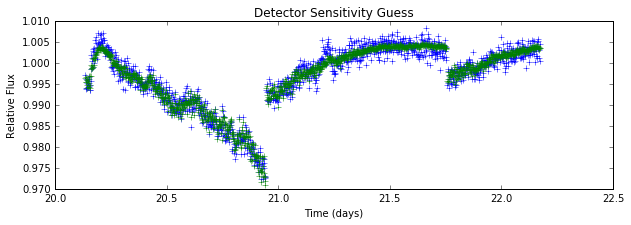

In [15]:
'''Adjust initial parameters'''

# fitting the residuals to get better polynomial guess
u_detec = [100, 100, 100, 100, 100, 100]
l_detec = [-100, -100, -100, -100, -100, -100]
p_detec = fit_residual(flux, time, xdata, ydata, p0_astro, p0_phase, p0_detec, u_detec, l_detec)
c1, c2, c3, c4, c5, c6 = p_detec

G = ideal_lightcurve2(time, t0, rp, a, inc, ecc, w, c_2, c_3, c_4, fp, A, B)
D = detec_model(xdata, ydata, c1, c2, c3, c4, c5, c6, mid_x, mid_y)

print(p_detec)

# update p0
#p0 = np.array([t0, per, rp, a, inc, ecc, w, u1, u2, fp,a1, a2, t1, t2, c1, c2, c3, c4, c5, c6, c7, c8, c9, c10])
p0 = np.array([t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, fp, A, B, c1, c2, c3, c4, c5, c6])

plt.figure(figsize=(10,3))
#plt.plot(time, flux)
plt.plot(time, flux/G, '+')
plt.plot(time, D, '+')
plt.title('Detector Sensitivity Guess')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')

In [16]:
'''Log likelihood function'''
def lnlike(p0, time, flux, xdata, ydata, flux_err, mid_x, mid_y):
    # unpack p0
    t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, fp, A, B, c1, c2, c3, c4, c5, c6 = p0
    # define model
    model = signal(time, t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, 
                   fp, A, B, xdata, ydata, c1, c2, c3, c4, c5, c6, mid_x, mid_y)
    inv_sigma2 = 1.0/(flux_err**2)
    return -0.5*(np.sum((flux-model)**2*inv_sigma2 - np.log(inv_sigma2)))

'''Probability distribution to draw sample from'''
def lnprior(p0):
    t0, rp, a, inc, ecc, w, alpha_h, alpha_r, alpha_t, fp, A, B, c1, c2, c3, c4, c5, c6 = p0
    # gaussian prior for a
    lgpri_a = -0.5*(((a - 6.70)/0.03)**2.0)
    # gaussian prior for i
    lgpri_i = -0.5*(((inc - 87.84)/0.1)**2.0)
    # gaussian prior for eccentricity
    lgpri_e = -0.5*(((ecc - 0.0143)/0.0077)**2.0)
    # uniform prior for the rest
    if (21.0 < t0 < 21.5 and 0 < rp < 1 and 88 < w < 110 and 0 < fp < 1 and
        0 < alpha_h < 1 and 0 < alpha_r < 1 and 0 < alpha_t < 1 and
        -0.707 < A < 0.707 and -0.407 < B < 0.407):
        return 0.0 + lgpri_a + lgpri_i + lgpri_e
    return -np.inf

'''Total probability function'''
def lnprob(p0, time, flux, xdata, ydata, flux_err, mid_x, mid_y):
    lp = lnprior(p0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p0, time, flux, xdata, ydata, flux_err, mid_x, mid_y)

In [17]:
'''Getting ready for MCMC'''

# total nb steps
totalsteps = 0
# instruction for sampling
ndim, nwalkers, nstep = 18, 200, 3000
# get scattered starting point in parameter space 
pos = [p0 + 10**(-5)*np.random.randn(ndim) for i in range(nwalkers)]
#sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(time, flux, xdata, ydata, flux_err, mid_x, mid_y))

In [18]:
'''Running MCMC'''
print("Running MCMC...")
tic = t.clock()
pos2, prob2, state2 = sampler.run_mcmc(pos, nstep)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)
totalsteps += nstep

Running MCMC...
Done.
time taken: 
368800.06687741517


# Saving MCMC Results

In [19]:
'''Save Chain'''
pathchain = foldername + '/samplerchainPoly2_LDC3.npy'
np.save(pathchain, sampler.chain)

In [20]:
#print the results



samples = sampler.chain[:,:,:].reshape((-1, ndim))
(t0_mcmc, rp_mcmc, a_mcmc, inc_mcmc, ecc_mcmc, 
 w_mcmc, ah_mcmc, ar_mcmc, at_mcmc, fp_mcmc, A_mcmc, B_mcmc, 
 c1_mcmc, c2_mcmc, c3_mcmc, c4_mcmc, c5_mcmc, c6_mcmc) = map(
    lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("""MCMC result:

    t0  = {0[0]} +{0[1]} -{0[2]} (Guess: {1})
    rp  = {2[0]} +{2[1]} -{2[2]} (Gillon: {3})
    a   = {4[0]} +{4[1]} -{4[2]} (Gillon: {5})
    inc = {6[0]} +{6[1]} -{6[2]} (Gillon: {7})
    ecc = {8[0]} +{8[1]} -{8[2]} (Guess: {9})
    w   = {10[0]} +{10[1]} -{10[2]} (Gillon: {11})
    ah  = {12[0]} +{12[1]} -{12[2]} (Gillon: {13})
    ar  = {14[0]} +{14[1]} -{14[2]} (Guess: {15})
    at  = {16[0]} +{16[1]} -{16[2]} (Guess: {17})
    fp   = {18[0]} +{18[1]} -{18[2]} (Guess: {19})
    
    A   = {20[0]} +{20[1]} -{20[2]} (Guess: {21})
    B  = {22[0]} +{22[1]} -{22[2]} (Guess: {23})
    
    c1 = {24[0]} +{24[1]} -{24[2]} (Guess: {25})
    c2 = {26[0]} +{26[1]} -{26[2]} (Guess: {27})
    c3 = {28[0]} +{28[1]} -{28[2]} (Guess: {29})
    c4 = {30[0]} +{30[1]} -{30[2]} (Guess: {31})
    c5 = {32[0]} +{32[1]} -{32[2]} (Guess: {33})
    c6 = {34[0]} +{34[1]} -{34[2]} (Guess: {35})
    
""".format(t0_mcmc, t0, rp_mcmc, rp, a_mcmc, a, inc_mcmc, inc, 
           ecc_mcmc, ecc, w_mcmc, w, ah_mcmc, alpha_h, ar_mcmc, alpha_r,
           at_mcmc, alpha_t, fp_mcmc, fp,
           A_mcmc, A, B_mcmc, B, c1_mcmc, c1,
           c2_mcmc, c2, c3_mcmc, c3, c4_mcmc, c4, c5_mcmc, c5, c6_mcmc, c6))  

ResultMCMC_Params = Table()
ResultMCMC_Params['t0'] = [t0_mcmc]
#ResultMCMC_Params['per'] =[ per_mcmc]
ResultMCMC_Params['rp'] = [rp_mcmc]
ResultMCMC_Params['a'] = [a_mcmc] 
ResultMCMC_Params['inc'] = [inc_mcmc]
ResultMCMC_Params['ecc'] = [ecc_mcmc]
ResultMCMC_Params['w'] = [w_mcmc]
ResultMCMC_Params['ah'] = [ah_mcmc]
ResultMCMC_Params['ar'] = [ar_mcmc]
ResultMCMC_Params['at'] = [at_mcmc]
ResultMCMC_Params['fp'] = [fp_mcmc]

ResultMCMC_Params['A'] = [A_mcmc]
ResultMCMC_Params['B'] = [B_mcmc]

ResultMCMC_Params['c1'] = [c1_mcmc]
ResultMCMC_Params['c2'] = [c2_mcmc]
ResultMCMC_Params['c3'] = [c3_mcmc]
ResultMCMC_Params['c4'] = [c4_mcmc]
ResultMCMC_Params['c5'] = [c5_mcmc]
ResultMCMC_Params['c6'] = [c6_mcmc]

pathres = foldername + '/ResultMCMC_Poly2_LDC3_Params.npy'
np.save(pathres, ResultMCMC_Params)

MCMC result:

    t0  = 21.20993448399179 +0.00023431427520037573 -0.00024228331863795916 (Guess: 21.20995)
    rp  = 0.1680515231731785 +0.001303080153675057 -0.001752629500001407 (Gillon: 0.168584)
    a   = 6.66936162923372 +0.029056856584210422 -0.029730631281620568 (Gillon: 6.7)
    inc = 87.93433105694703 +0.16193260100487805 -0.1152437955878014 (Gillon: 88.1036)
    ecc = 0.007796537158493803 +0.005221040741434036 -0.005139237656699977 (Guess: 0.0143)
    w   = 96.17445148134793 +5.449482400625797 -1.142126506642441 (Gillon: 96.147)
    ah  = 0.07435254189642197 +0.4240172333476466 -0.06753601742475243 (Gillon: 0.5)
    ar  = 0.6826073956635201 +0.23901136063247663 -0.20804780044874677 (Guess: 0.5)
    at  = 0.42217023932089104 +0.07778188653900564 -0.0799821286035024 (Guess: 0.5)
    fp   = 0.0042551353987317405 +0.00025077564573070324 -0.0002514480153518678 (Guess: 0.0042)
    
    A   = 0.48873013759892187 +0.02845209409873234 -0.028916106890741144 (Guess: 0.491219)
    B  = 

In [21]:
def walk_style(ndim,nwalk,samp,burn,inc, steps):  # inc is take every # element (thins out plots)
    # steps if number of last steps you want to see
    samp2show = samp.chain[:,-steps:,:]
    max_t = samp2show.shape[1]
    t_V = np.arange(max_t)
    t_V = t_V[burn::inc]
    j_easy = 25  # To thin the number of knots plotted
    
    
    nrows = np.ceil(ndim/4)
    plt.figure(figsize=(16, 3*nrows))

    jin = 7  # Special knot indexing
    for j in np.linspace(0,ndim-1,ndim):
        plt.subplot(3,4,j+1)
        mu_param = np.mean(samp2show[:,:,j][:,burn::inc],axis=0)
        std_param = np.std(samp2show[:,:,j][:,burn::inc],axis=0)
        plt.plot(t_V,mu_param,'k--')
        plt.fill_between(t_V,mu_param + 3.0*std_param,mu_param - 3.0*std_param,facecolor='k',alpha=0.1)
        plt.fill_between(t_V,mu_param + 2.0*std_param,mu_param - 2.0*std_param,facecolor='k',alpha=0.1)
        plt.fill_between(t_V,mu_param + 1.0*std_param,mu_param - 1.0*std_param,facecolor='k',alpha=0.1)
        
        if j < ndim:
            plt.title(v_labels[j],size=16)
            plt.plot(np.array([0,max_t]),np.array([p0[j], p0[j]]),'g',linewidth=2)
        if j < (ndim-4):
            plt.xticks([])
        else:
            plt.xticks(rotation=25)
    return

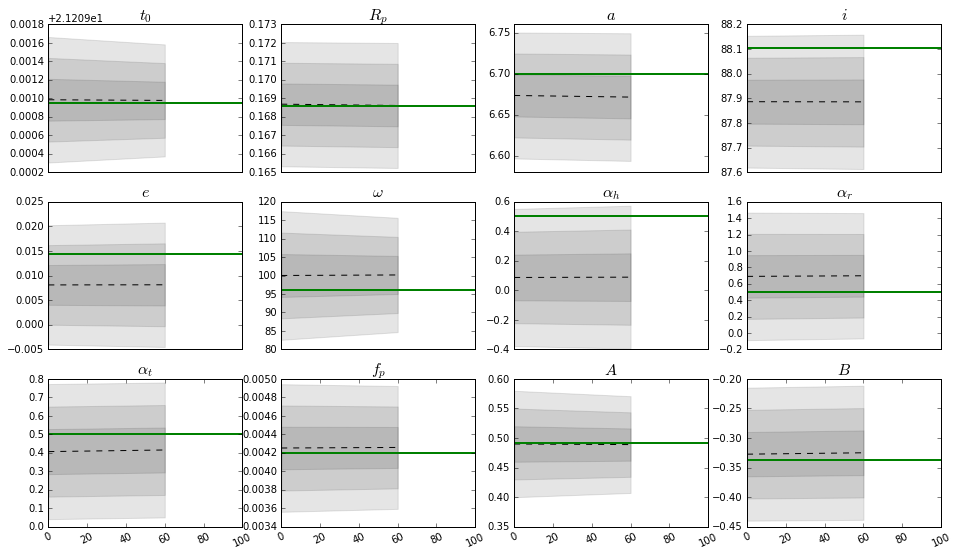

In [22]:
Viz_key = True
v_labels = np.array(['$t_0$','$R_p$','$a$','$i$','$e$', '$\omega$',
                     r'$\alpha _h$',r'$\alpha _r$', r'$\alpha _t$','$f_p$', '$A$', '$B$'],dtype='object_')
import warnings
warnings.filterwarnings("ignore")

if Viz_key == True:
    walk_style(12,nwalkers,sampler, 0, totalsteps/50, 100)

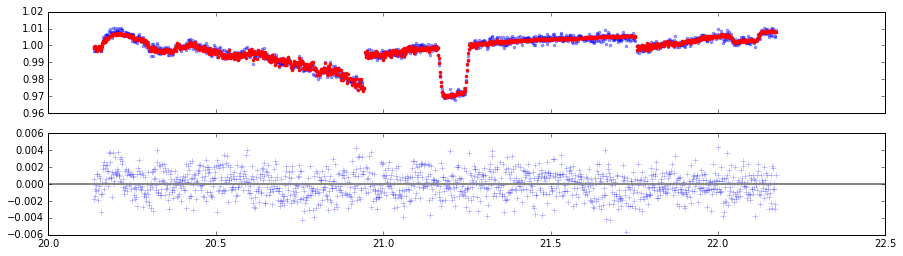

In [23]:
'''signal_result = signal(time, t0_mcmc[0], per_mcmc[0], rp_mcmc[0], a_mcmc[0], inc_mcmc[0], ecc_mcmc[0], 
                       w_mcmc[0], u1_mcmc[0], u2_mcmc[0], fp_mcmc[0], a1_mcmc[0], a2_mcmc[0], t1_mcmc[0], 
                       t2_mcmc[0], xdata, ydata, c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                       c6_mcmc[0], c7_mcmc[0], c8_mcmc[0], c9_mcmc[0], c10_mcmc[0], mid_x, mid_y)'''

signal_result = signal(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], inc_mcmc[0], ecc_mcmc[0], 
                        w_mcmc[0], ah_mcmc[0], ar_mcmc[0], at_mcmc[0], fp_mcmc[0], A_mcmc[0], B_mcmc[0],
                        xdata, ydata, c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                        c6_mcmc[0], mid_x, mid_y)

fig, axes = plt.subplots(ncols = 1, nrows = 2, sharex = True,figsize=(15,4))
axes[0].plot(time, flux, 'b.', alpha = 0.4)
axes[0].plot(time, signal_result, 'r.')
axes[1].plot(time, flux - signal_result, '+', alpha = 0.4)
axes[1].axhline(y=0, color="#888888", lw=2)

In [39]:
c_2_mcmc, c_3_mcmc, c_4_mcmc = forward_LD(ah_mcmc[0], ar_mcmc[0], at_mcmc[0])

res_det = detec_model(xdata, ydata, c1_mcmc[0], c2_mcmc[0], c3_mcmc[0], c4_mcmc[0], c5_mcmc[0], 
                      c6_mcmc[0], mid_x, mid_y)

res_lightcurve = ideal_lightcurve2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0], ecc_mcmc[0], w_mcmc[0], c_2_mcmc, c_3_mcmc, c_4_mcmc, 
                                   fp_mcmc[0], A_mcmc[0], B_mcmc[0])

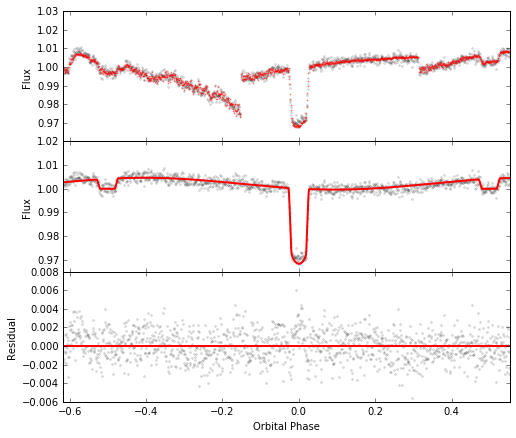

In [42]:
fig, axes = plt.subplots(ncols = 1, nrows = 3, sharex = True, figsize=(8, 7))
axes[0].set_xlim((np.min(time)-t0_mcmc[0])/per, (np.max(time)-t0_mcmc[0])/per)
axes[0].plot((time-t0_mcmc[0])/per, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[0].plot((time-t0_mcmc[0])/per, res_lightcurve*res_det, '.', color = 'r', markersize = 2.5, alpha = 0.4)
axes[0].set_yticks(np.arange(0.97, 1.03, 0.01))
axes[0].set_ylabel('Flux')

axes[1].plot((time-t0_mcmc[0])/per, flux/res_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[1].plot((time-t0_mcmc[0])/per, res_lightcurve, color = 'r', linewidth=2)
#axes[1].axhline(y=1, color='b', linewidth = 2)
#axes[1].axhline(y=1+fp_mcmc[0], color='b', linewidth = 2)
axes[1].set_yticks(np.arange(0.97, 1.02, 0.01))
axes[1].set_ylabel('Flux')

axes[2].plot((time-t0_mcmc[0])/per, flux/res_det - res_lightcurve, 'k.', markersize = 4, alpha = 0.15)
axes[2].axhline(y=0, color='r', linewidth = 2)
axes[2].set_ylabel('Residual')
axes[2].set_xlabel('Orbital Phase')

fig.subplots_adjust(hspace=0)
plotname = foldername + '/MCMC_Poly2_LDC3_2.pdf'
fig.savefig(plotname, bbox_inches='tight')

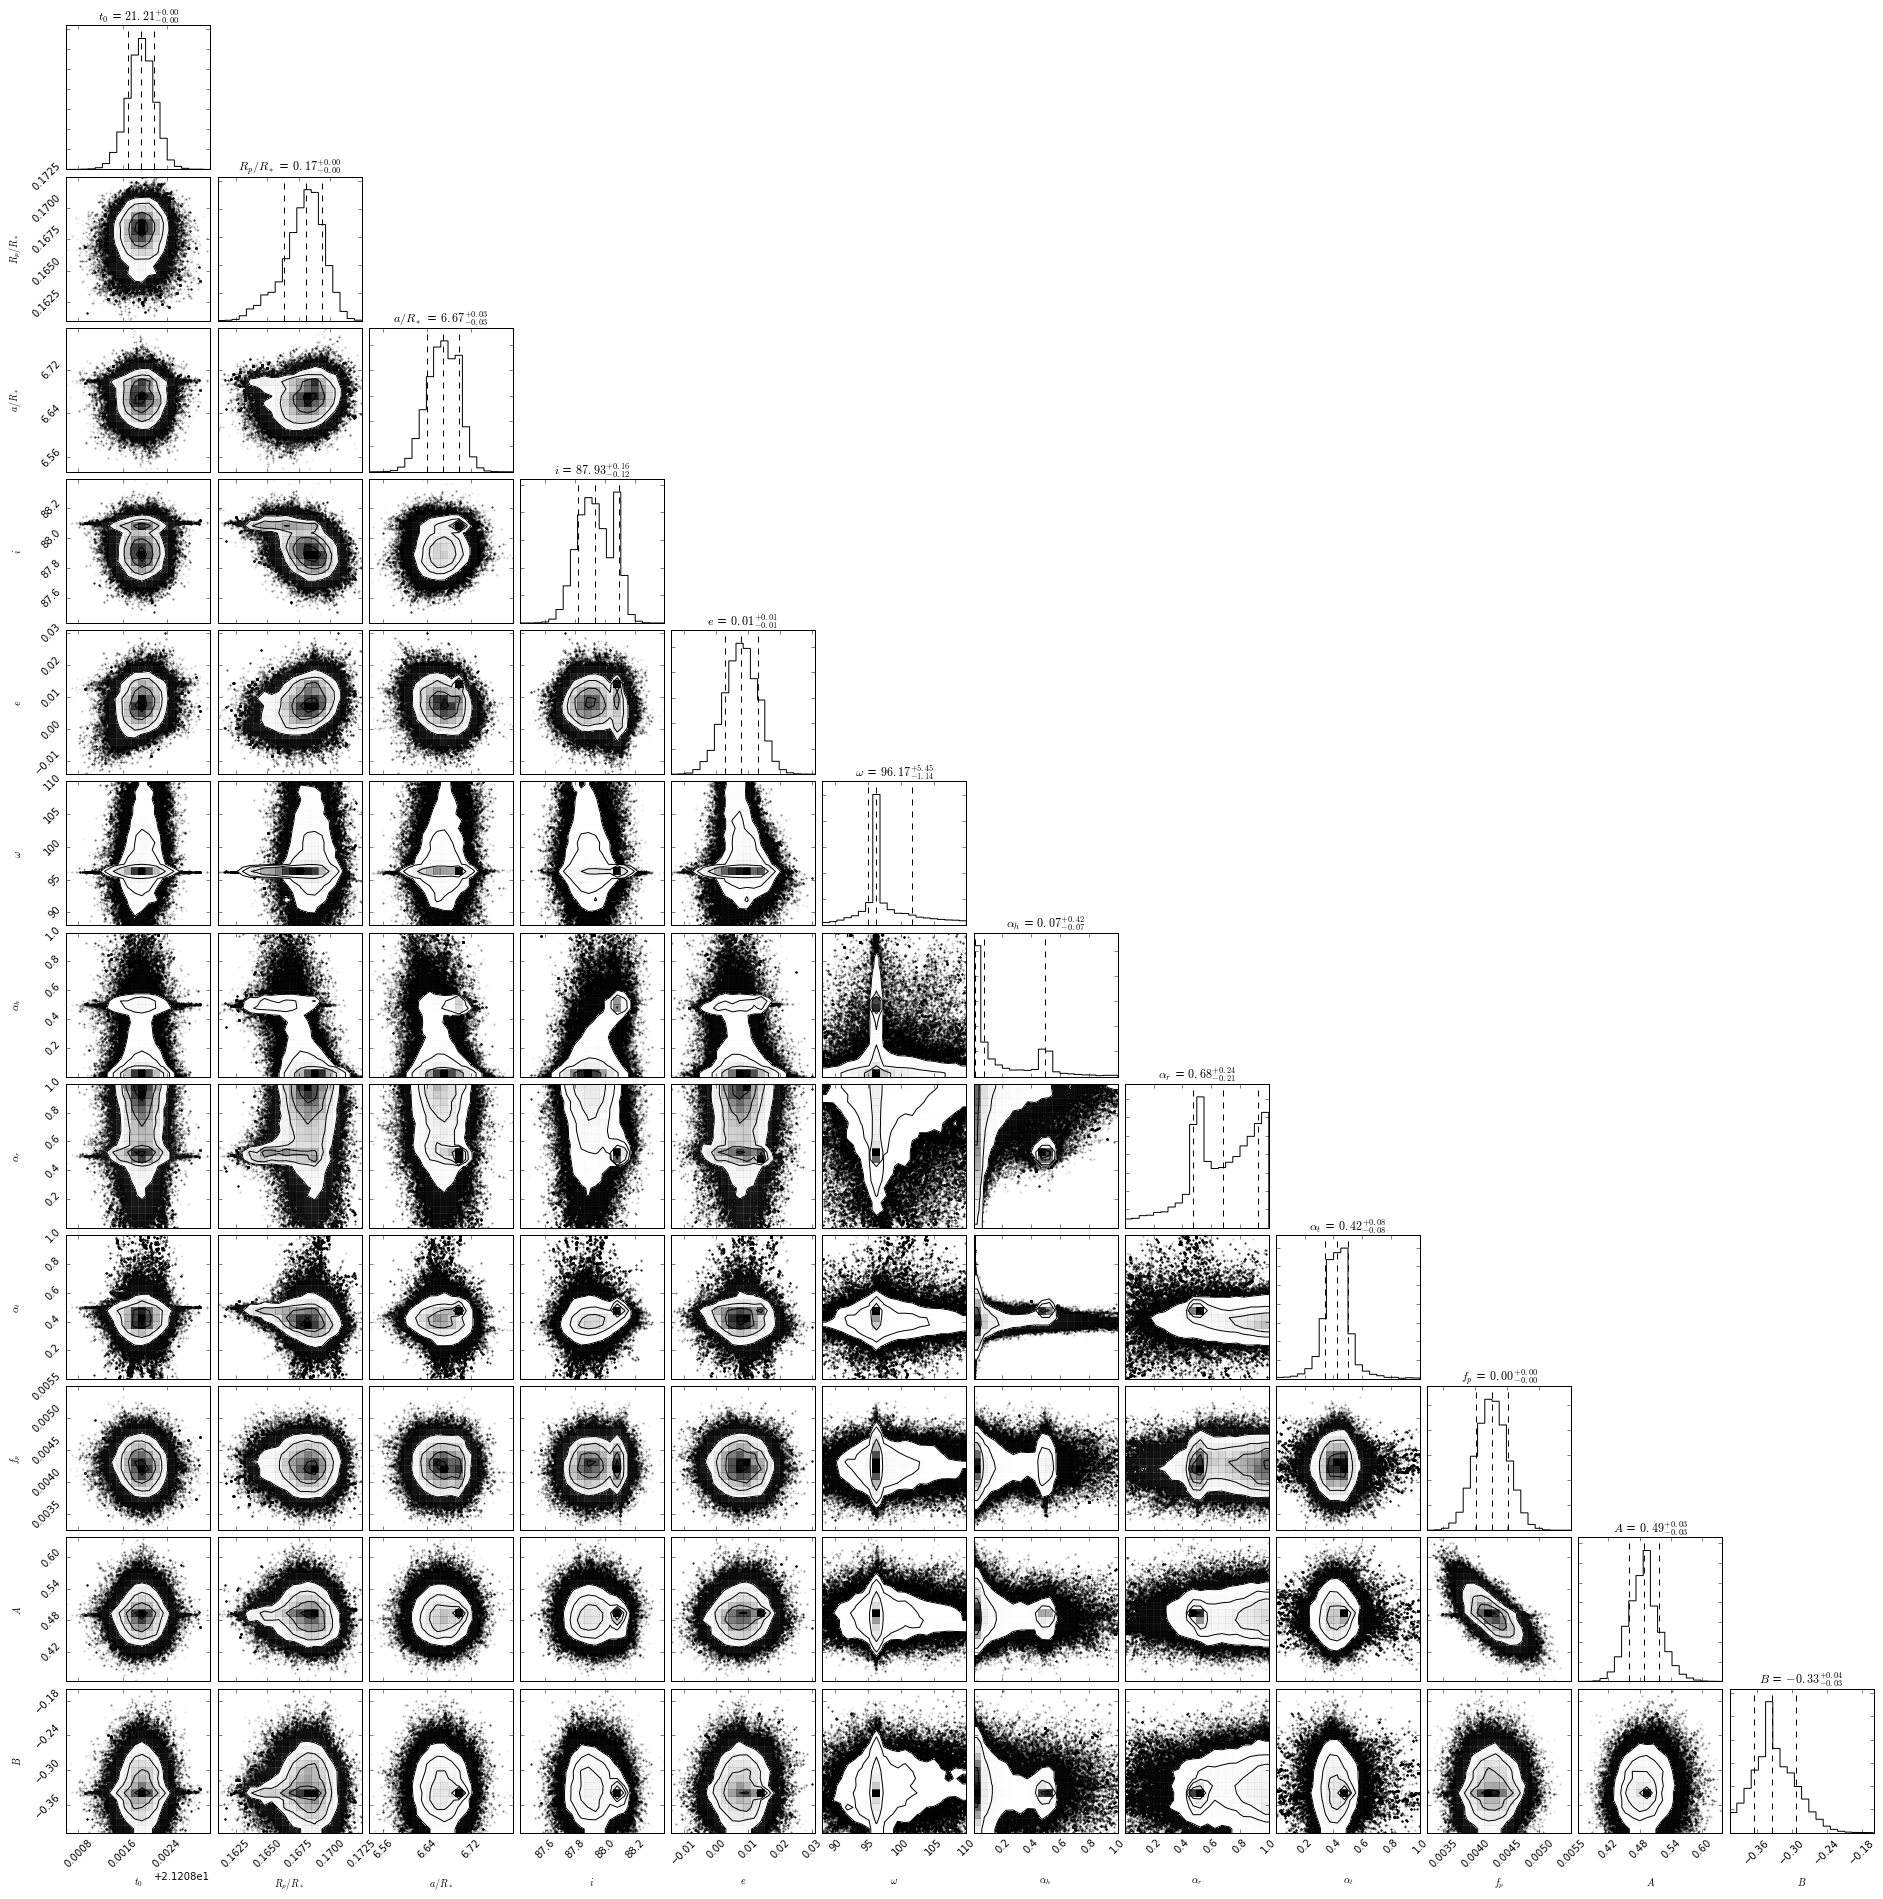

In [24]:
fig = corner.corner(samples[:,0:12], labels=["$t_0$","$R_p/R_*$", "$a/R_*$", "$i$",
                                             "$e$", "$\omega$", r'$\alpha _h$',r'$\alpha _r$', r'$\alpha _t$', '$f_p$', '$A$', '$B$'], 
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plotname = foldername + '/MCMC_Poly2_LDC3_3.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [ ]:
'''PSF Diagnotics'''
residual = flux/res_det - res_lightcurve

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4,4)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex = ax1)
ax3 = fig.add_subplot(gs[1,1], sharey = ax2)
ax4 = fig.add_subplot(gs[2,0], sharex = ax1)
ax5 = fig.add_subplot(gs[2,1], sharex = ax3, sharey = ax4)
ax6 = fig.add_subplot(gs[2,2], sharey = ax4)
ax7 = fig.add_subplot(gs[3,0], sharex = ax1)
ax8 = fig.add_subplot(gs[3,1], sharey = ax7, sharex =ax3)
ax9 = fig.add_subplot(gs[3,2], sharey = ax7, sharex = ax6)
ax10 = fig.add_subplot(gs[3,3], sharey = ax7)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax5.get_yticklabels(), visible=False)
plt.setp(ax6.get_yticklabels(), visible=False)
plt.setp(ax8.get_yticklabels(), visible=False)
plt.setp(ax9.get_yticklabels(), visible=False)
plt.setp(ax10.get_yticklabels(), visible=False)

ax1.set_ylabel("$y_0$")
ax2.set_ylabel("$\sigma _x$")
ax4.set_ylabel("$\sigma _y$")
ax7.set_ylabel("Flux Residuals")

ax7.set_xlabel("$x_0$")
ax8.set_xlabel("$y_0$")
ax9.set_xlabel("$\sigma _x$")
ax10.set_xlabel("$\sigma_y$")

ax1.plot(xdata, ydata, 'k.', markersize = 0.5)
ax2.plot(xdata, psfxw, 'k.', markersize = 0.5)
ax3.plot(ydata, psfxw, 'k.', markersize = 0.5)
ax4.plot(xdata, psfyw, 'k.', markersize = 0.5)
ax5.plot(ydata, psfyw, 'k.', markersize = 0.5)
ax6.plot(psfxw, psfyw, 'k.', markersize = 0.5)
ax7.plot(xdata, residual, 'k.', markersize = 0.5)
ax8.plot(ydata, residual, 'k.', markersize = 0.5)
ax9.plot(psfxw, residual, 'k.', markersize = 0.5)
ax10.plot(psfyw, residual, 'k.', markersize = 0.5)

'''ax1.plot(xdata_out, ydata_out, 'k.', markersize = 0.5)
ax2.plot(xdata_out, psfxw_out, 'k.', markersize = 0.5)
ax3.plot(ydata_out, psfxw_out, 'k.', markersize = 0.5)
ax4.plot(xdata_out, psfyw_out, 'k.', markersize = 0.5)
ax5.plot(ydata_out, psfyw_out, 'k.', markersize = 0.5)
ax6.plot(psfxw_out, psfyw_out, 'k.', markersize = 0.5)
ax7.plot(xdata_out, flux_out, 'k.', markersize = 0.5)
ax8.plot(ydata_out, flux_out, 'k.', markersize = 0.5)
ax9.plot(psfxw_out, flux_out, 'k.', markersize = 0.5)
ax10.plot(psfyw_out, flux_out, 'k.', markersize = 0.5)
'''
#ax1.set_xticks(rotation='vertical')
#ax2.set_xticks(rotation='vertical')
#ax3.set_xticks(rotation='vertical')
#ax4.set_xticks(rotation='vertical')
#ax5.set_xticks(rotation='vertical')
#ax6.set_xticks(rotation='vertical')
ax1.set_yticks(np.arange(15, 15.25, 0.1))
ax2.set_yticks(np.arange(0.62, 0.75, 0.03))
ax4.set_yticks(np.arange(0.7, 0.72, 0.01))
ax7.set_yticks(np.arange(-0.006, 0.004, 0.003))
ax7.set_xticks(np.arange(14.98, 15.25, 0.12))
ax8.set_xticks(np.arange(15.0, 15.30, 0.1))
ax9.set_xticks(np.arange(0.63, 0.77, 0.05))
ax10.set_xticks(np.arange(0.705, 0.74, 0.015))

#ax1.axhline(y=15.18, color ='k', alpha=0.3)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
#fig.tight_layout()
pathplot2 = foldername + '/MCMC_Poly2_LDC3_4.pdf'
fig.savefig(pathplot2,bbox_inches='tight')

In [ ]:
def chi2(data, fit, err):
    N     = len(data)
    denom = (data - fit)**2
    numer = err**2
    chi2  = np.sum(denom/numer)
    return chi2

data = (flux/res_det)
fit  = res_lightcurve 
chis = chi2(data, fit, flux_err)

print('$\chi ^2$: ', chis)

def loglikelihood(data, fit, err):
    inv_sigma2 = 1.0/(err**2)
    return -0.5*(np.sum((data-fit)**2*inv_sigma2 - np.log(inv_sigma2)))

def BIC(logL, Npar, Ndat):
    E = logL - (Npar/2)*np.log(Ndat)
    return E

logL = loglikelihood(data, fit, flux_err)
print('Likelihood: ',logL)
E = BIC(logL, ndim, len(data))
print('Evidence: ',E)